# 第8章 自相关

1. 时间序列的处理
2. 残差图
3. BG检验
4. Q检验
5. DW检验
6. HAC稳健标准误
7. 处理一阶自相关的FGLS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 读取数据
ts = pd.read_stata('../2_Data/Data-2e/icecream.dta')
x = ts['time']
y1 = ts['consumption']
y2 = ts['temp']
# 获得ts的行数



### 2.画图

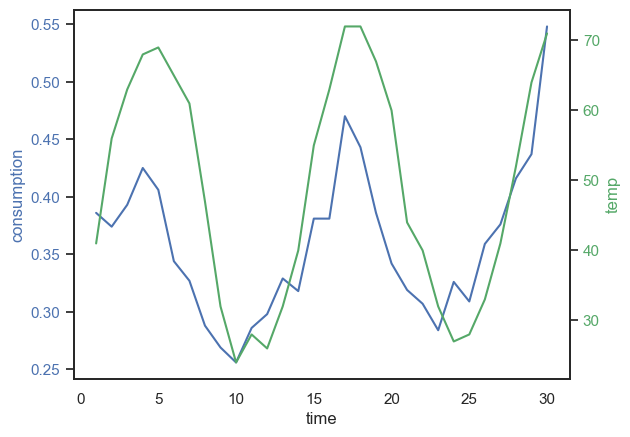

In [2]:
sns.set_theme(
    # context='talk', 
    style="white"
    )  # 设置seaborn的风格

# 创建一个图形
fig, ax1 = plt.subplots()
# 使用seaborn绘制第一个数据集
sns.lineplot(x=x, y=y1, ax=ax1, color="b")  # ax1 作为关键字参数
# 创建第二个y轴
ax2 = ax1.twinx()
# 使用seaborn绘制第二个数据集
sns.lineplot(x=x, y=y2, ax=ax2, color="g")  # ax2 作为关键字参数

# 设置标签
ax1.set_xlabel('time')
ax1.set_ylabel('consumption', color="b")  # Y1轴的标签和刻度标签颜色
ax1.tick_params(axis='y', labelcolor="b")  # Y1轴的刻度标签颜色
ax2.set_ylabel('temp', color="g")  # Y2轴的标签和刻度标签颜色
ax2.tick_params(axis='y', labelcolor="g")  # Y2轴的刻度标签颜色

In [3]:
X = ts[['temp','price','income']]
y = ts['consumption']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     22.17
Date:                Sat, 04 May 2024   Prob (F-statistic):           2.45e-07
Time:                        04:34:46   Log-Likelihood:                 58.619
No. Observations:                  30   AIC:                            -109.2
Df Residuals:                      26   BIC:                            -103.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1973      0.270      0.730      0.4

#### 1.时间序列处理

按照代码实现的顺序，将时间序列处理调整到这里，对应教程8.5的[1.时间序列因子]

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4.801
Date:                Sat, 04 May 2024   Prob (F-statistic):             0.0373
Time:                        04:34:46   Log-Likelihood:                 60.858
No. Observations:                  29   AIC:                            -117.7
Df Residuals:                      27   BIC:                            -115.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.006     -0.238      0.8

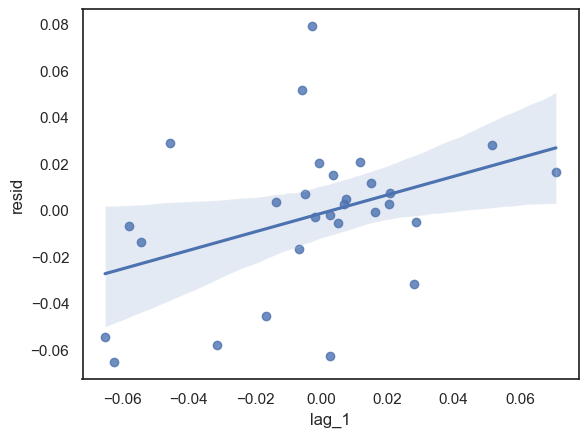

In [4]:
ts_resid = ts.copy()
ts_resid['resid'] = results.resid
# ts_resid['lag_resid'] = results.resid.shift(1)
ts_resid['lag_1']=ts_resid['resid'].shift(1)
ts_resid = ts_resid.dropna()

# 对 resid = beta0 + beta1*lag_1 + epsilon 进行回归
X = ts_resid['lag_1']
y = ts_resid['resid']
X = sm.add_constant(X)
emodel = sm.OLS(y,X)
eresults = emodel.fit()
sns.regplot(y='resid', x='lag_1', data=ts_resid)
print(eresults.summary())

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                   0.02728
Date:                Sat, 04 May 2024   Prob (F-statistic):              0.870
Time:                        04:34:46   Log-Likelihood:                 53.667
No. Observations:                  27   AIC:                            -103.3
Df Residuals:                      25   BIC:                            -100.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.007     -0.444      0.6

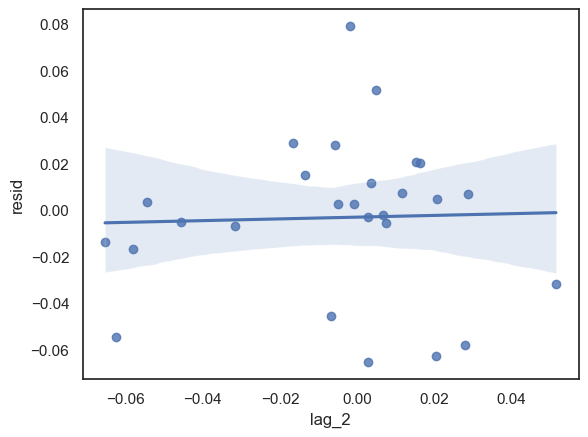

In [5]:
# 对 resid = beta0 + beta1*lag_2 + epsilon 进行回归
ts_resid['lag_2']=ts_resid['resid'].shift(2)
ts_resid = ts_resid.dropna()
X = ts_resid['lag_2']
y = ts_resid['resid']
X = sm.add_constant(X)
emodel = sm.OLS(y,X)
eresults = emodel.fit()
sns.regplot(y='resid', x='lag_2', data=ts_resid)
print(eresults.summary())


#### 残差自相关图

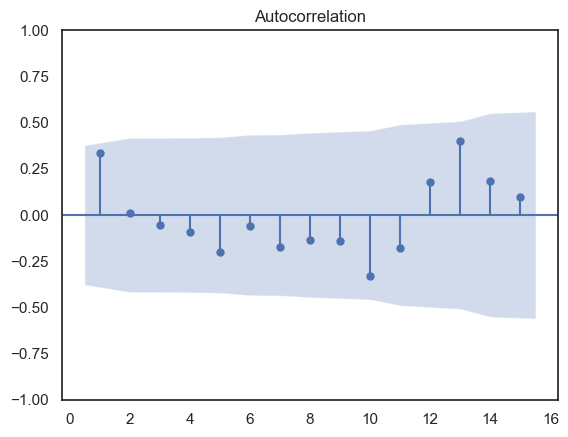

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(y, ax=plt.gca(),zero=False,lags=15)
plt.show()

### 3.BG检验

In [7]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

lag = 1  # 假设我们检验1阶自相关
bg_result = acorr_breusch_godfrey(results, nlags=1)
print("BG检验的LM统计量:{:.4f}".format(bg_result[0]))
print("BG检验的LM统计量P值:{:.4f}".format(bg_result[1]))
if bg_result[1]<0.05:
    print("拒绝原假设,模型存在自相关.")
else:
    print("接受原假设，模型不存在自相关.")

# print("BG检验的F统计量为:{:.4f}".format(bg_result[2]))
# print("BG检验的F统计量P值:{:.4f}".format(bg_result[3]))
# if bg_result[3]<0.05:
#     print("拒绝原假设,模型存在自相关")
# else:
#     print("接受原假设，模型不存在自相关")

BG检验的LM统计量:4.2371
BG检验的LM统计量P值:0.0396
拒绝原假设,模型存在自相关.


### 4.Q检验

In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox

bp_result = acorr_ljungbox(results.resid, 
                           lags=[i for i in range(1, 14)],
                           boxpierce=True, 
                           return_df=True,
                           # auto_lag=True
                           )
bp_result

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,3.600000,0.057780,3.262500,0.070881
2,3.645048,0.161617,3.301917,0.191866
3,3.649399,0.301896,3.305588,0.346866
4,3.971467,0.409881,3.567269,0.467724
5,7.870307,0.163530,6.613237,0.251029
6,9.564491,0.144231,7.883875,0.246735
7,12.346118,0.089736,9.883170,0.195291
8,13.168659,0.106177,10.448666,0.234936
9,13.657982,0.135022,10.769785,0.291820
10,16.371766,0.089473,12.465900,0.255084


### 5.DW检验

In [9]:
# 调用
dw = sm.stats.durbin_watson(results.resid)
print("Durbin-Watson statistic:", dw)

Durbin-Watson statistic: 1.0211693125331998


### 6.HAC标准误

验证模型存在自相关后，可采用HAC方法处理。

In [10]:
nw_cov_type = 'HAC'
p = int((len(ts)** 0.25 // 1) + 1)
nw_kwargs = {'maxlags': p,'use_correction':True}
nw_res = results.get_robustcov_results(cov_type=nw_cov_type, use_t=False, **nw_kwargs)
print(nw_res.summary())

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     27.63
Date:                Sat, 04 May 2024   Prob (F-statistic):           3.02e-08
Time:                        04:34:47   Log-Likelihood:                 58.619
No. Observations:                  30   AIC:                            -109.2
Df Residuals:                      26   BIC:                            -103.6
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1973      0.338      0.584      0.5

将截断参数扩大至6，然后对标准差进行对比，发现变化不大。
- 由于存在自相关，OLS不再是BLUE，所以可考虑使用FGLS来实现。

In [11]:
nw_cov_type = 'HAC'
nw_kwargs = {'maxlags': 6,'use_correction':True}
nw_res = results.get_robustcov_results(cov_type=nw_cov_type, use_t=False, **nw_kwargs)
print(nw_res.summary())

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     52.97
Date:                Sat, 04 May 2024   Prob (F-statistic):           3.28e-11
Time:                        04:34:47   Log-Likelihood:                 58.619
No. Observations:                  30   AIC:                            -109.2
Df Residuals:                      26   BIC:                            -103.6
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1973      0.330      0.598      0.5

## 7.处理一阶自相关的FGLS

### （1）使用CO估计法
这个过程非常繁琐，因为没有找到statsmodels包中有相关的函数，CO方法的实现代码肯定不是最优的，但是结果是与教材最接近的。

In [12]:
# 使用CO方法 需要多次迭代 <-- 这是错的！
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# 读取原始数据
icecream = pd.read_stata('../2_Data/Data-2e/icecream.dta')
X = icecream[['temp','price','income']]
y = icecream['consumption']
X = sm.add_constant(X)

# 初始OLS回归
model = sm.OLS(y,X)
results = model.fit() 

# 计算误差项的各期滞后值：dataframe格式 
# todo：这里不对，需要修改
resid = pd.DataFrame()
for i in  range(len(icecream)):
	lag_n =  f'lag_{i}'
	resid[lag_n] = results.resid.shift(i)

# Cochrane-Orcutt迭代过程
converged =  False
iterations =  0
max_iterations =  10  # 设置最大迭代次数
tolerance =  0.0001  # 设置收敛容差
hat_rho = [0]
results_list = [ ]

while  not converged and iterations < max_iterations:

	# 拟合AR(1)模型来估计自相关系数
	# 残差数据处理
	lag_X =  'lag_{}'.format(iterations+1)
	lag_y =  'lag_{}'.format(iterations)
	resid_ols = resid.copy()[[lag_y, lag_X]]
	resid_ols.dropna(inplace=True)

	# 进行AR(1)模型拟合
	resid_X = resid_ols[lag_X]
	resid_y = resid_ols[lag_y]
	rho = sm.OLS(resid_y, resid_X).fit()
	hat_rho.append(rho.params.iloc[0])

	# 使用Cochrane-Orcutt变换调整误差项
	X_adj = X.copy() - X.copy().shift(1)*hat_rho[-1]
	y_adj = y.copy() - y.copy().shift(1)*hat_rho[-1]

	# 重新进行OLS回归，去除t0项
	results_new = sm.OLS(y_adj[1:], sm.add_constant(X_adj[1:])).fit()

	# 检查是否收敛
	if  abs(hat_rho[-1]-hat_rho[-2]) < tolerance:
	# if  abs(hat_rho[-1]) < tolerance:
		converged =  True
	else:
		results_list.append(results_new)
		results = results_new # 更新模型为新迭代的结果
		iterations +=  1
		print(f"迭代 {iterations}: rho = {hat_rho[-1]:.6f}")
		
print('【Cochrane-Orcutt】迭代结果------------------------')
print(results_list[-2].summary())

迭代 1: rho = 0.400633
迭代 2: rho = 0.408242
迭代 3: rho = 0.408111
迭代 4: rho = 0.408397
【Cochrane-Orcutt】迭代结果------------------------
                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     15.18
Date:                Sat, 04 May 2024   Prob (F-statistic):           7.87e-06
Time:                        04:34:47   Log-Likelihood:                 60.905
No. Observations:                  29   AIC:                            -113.8
Df Residuals:                      25   BIC:                            -108.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [ ]:
# 使用CO方法 需要多次迭代
import statsmodels.api as sm
import pandas as pd

# 读取原始数据,进行初始OLS回归
icecream = pd.read_stata('../2_Data/Data-2e/icecream.dta')
X = icecream[['temp','price','income']]
y = icecream['consumption']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit() 

# Cochrane-Orcutt迭代过程
converged =  False
iterations =  0
max_iterations =  10  # 设置最大迭代次数
tolerance =  0.001  # 设置收敛容差
hat_rho = [0]
results_list = [ ]

# 初始化第一轮的残差滞后数据
resid = pd.DataFrame()
resid['lag_0'] = results.resid
resid['lag_1'] = results.resid.shift(1)
resid['mu'] = 0
# print(resid.head())

while not converged and iterations < max_iterations:

	# 拟合AR(1)模型来估计自相关系数
    resid_ols = resid.copy()
    resid_ols.dropna(inplace=True)

	# 进行AR(1)模型拟合
    resid_X = resid_ols['lag_1']
    resid_y = resid_ols['lag_0']
    rho = sm.OLS(resid_y, resid_X).fit()
    hat_rho.append(rho.params.iloc[0])
    print(f"迭代 {iterations+1}: rho = {hat_rho[-1]:.6f}")
    
	# 使用Cochrane-Orcutt变换后再进行回归，得到新残差项
    X_adj = X.copy() - X.copy().shift(1)*hat_rho[-1]
    y_adj = y.copy() - y.copy().shift(1)*hat_rho[-1]
    results_new = sm.OLS(y_adj[1:], sm.add_constant(X_adj[1:])).fit()
    

	# 检查是否收敛
    if abs(hat_rho[-1]-hat_rho[-2]) < tolerance:
        converged =  True
    else:
        resid['mu'] = results_new.resid
        resid.loc[1:,'lag_0']= hat_rho[-1] * resid.loc[1:,'lag_1'] + resid['mu'][1:]
        resid['lag_1'] = resid['lag_0'].shift(1) 
        # print(resid.head(3))
        # 更新模型为新迭代的结果
        results = results_new
        results_list.append(results_new)
        iterations +=  1
		
print('【Cochrane-Orcutt】迭代结果------------------------')
print(results_list[-1].summary())

迭代 1: rho = 0.400633
迭代 2: rho = 0.396399
迭代 3: rho = 0.396524
【Cochrane-Orcutt】迭代结果------------------------
                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     15.54
Date:                Sat, 04 May 2024   Prob (F-statistic):           6.52e-06
Time:                        04:34:47   Log-Likelihood:                 60.905
No. Observations:                  29   AIC:                            -113.8
Df Residuals:                      25   BIC:                            -108.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

### （2）使用PW估计法
似乎也没有专门的prais-winsten估计方法的函数，需要在以上代码的基础上修改成pw方法。
最大的区别在于，第二步是对rho进行处理后，直接调整第1期方程的数值。

In [16]:
# 使用PW方法 替换t1期的数据

import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# 读取原始数据
icecream = pd.read_stata('../2_Data/Data-2e/icecream.dta')
X = icecream[['temp','price','income']]
y = icecream['consumption']
X = sm.add_constant(X)

# 初始OLS回归
model = sm.OLS(y,X)
results = model.fit()

# 对误差项进行回归，得到rho
resid = pd.DataFrame()
for i in range(2):
    lag_n = f'lag_{i}'
    resid[lag_n] = results.resid.shift(i)

# Cochrane-Orcutt迭代过程
converged = False
iterations = 0
max_iterations = 10  # 设置最大迭代次数
tolerance = 0.001  # 设置收敛容差
hat_rho = [0]
results_list = [ ]

while not converged and iterations < max_iterations:
# 进行AR(1)模型拟合
# 残差数据处理
    lag_X = 'lag_{}'.format(iterations+1)
    lag_y = 'lag_{}'.format(iterations)
    resid_ols = resid.copy()[[lag_y, lag_X]]
    resid_ols.dropna(inplace=True)

    # 进行AR(1)模型拟合
    resid_X = resid_ols[lag_X]
    resid_y = resid_ols[lag_y]
    # X = sm.add_constant(X) # 不加入常数项效果更好
    rho = sm.OLS(resid_y, resid_X).fit()
    hat_rho = rho.params.iloc[0]

    # 使用Prais-winsten方法对第一期方程进行调整
    ice_pw_copy = icecream.copy()[['temp','price','income','consumption']]
    ice_pw = ice_pw_copy - ice_pw_copy.shift(1)*hat_rho
    ice_pw.loc[0] = ice_pw_copy.loc[0]*((1-hat_rho**2)**0.5)

    # 重新进行OLS回归
    X_pw = ice_pw[['temp','price','income']]
    y_pw = ice_pw['consumption']
    X_pw = sm.add_constant(X_pw)
    results_new = sm.OLS(y_pw, X_pw).fit()



print('【Prais-Winsten】方法结果------------------------')
print(f'rho={hat_rho:.4f}')
print(results_new.summary())

#todo： 确定迭代次数的逻辑还没有理清楚，需要研究State的CO法实现过程



KeyboardInterrupt: 

In [15]:
from math import sqrt

hat_rho = 0.5

icecream = pd.read_stata('../2_Data/Data-2e/icecream.dta')
ice_pw_copy = icecream.copy()[['temp','price','income','consumption']]
print(ice_pw_copy.head())
ice_pw = ice_pw_copy - ice_pw_copy.shift(1)*hat_rho
ice_pw.loc[0] = ice_pw_copy.loc[0]*((1-hat_rho**2)**0.5)

ice_pw

   temp  price  income  consumption
0  41.0  0.270    78.0        0.386
1  56.0  0.282    79.0        0.374
2  63.0  0.277    81.0        0.393
3  68.0  0.280    80.0        0.425
4  69.0  0.272    76.0        0.406


,temp,price,income,consumption
0,35.507042,0.233827,67.54998,0.334286
1,35.500000,0.147000,40.00000,0.181000
2,35.000000,0.136000,41.50000,0.206000
3,36.500000,0.141500,39.50000,0.228500
4,35.000000,0.132000,36.00000,0.193500
5,30.500000,0.126000,40.00000,0.141000
6,28.500000,0.144000,43.00000,0.155000
7,16.500000,0.129500,38.00000,0.124500
8,8.500000,0.131500,36.50000,0.125000
9,8.000000,0.144500,41.00000,0.121500
